# Ejercicio clase - grupal

Realizar un ajuste usando PyMC de un GLM de la práctica 4. Graficar la posterior de los parámetros. Graficar los datos y el HDI de la posterior predictive.

### Desarrollo

Para este caso decidí ajustar el GLM propuesto en el **[ejercicio 7 de la guía 4](../guia_4/ejercicio_7_guia.ipynb)**. Por lo tanto paso a cargar los datos 
de dicho ejercicio:

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

ruta_datos_nambe = os.path.join('..', '..','datos', 'raw' ,'nambeware.csv')

df_nambe = pd.read_csv(ruta_datos_nambe, index_col=0)

df_nambe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Type    59 non-null     object 
 1   Diam    59 non-null     float64
 2   Time    59 non-null     float64
 3   Price   59 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.3+ KB


Hago un gráfico para recordar como se relacionaba la variable objetivo respecto de la predictora:

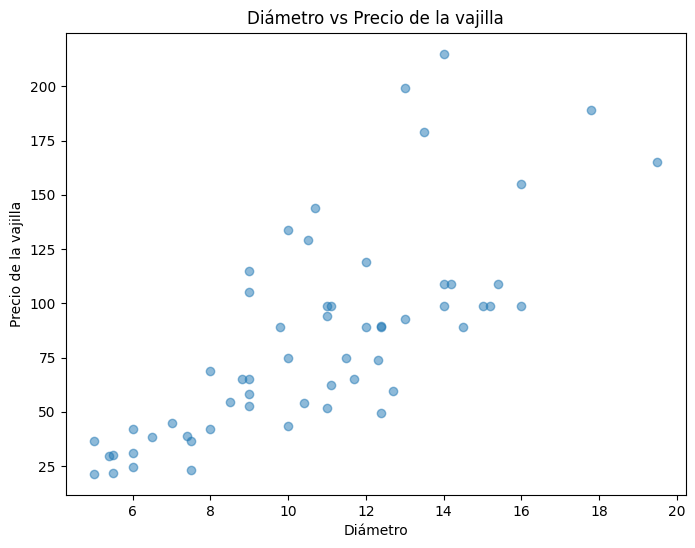

In [ ]:
import matplotlib.pyplot as plt

# Elimino outliers
df_nambe = df_nambe[df_nambe['Diam'] < 20]

plt.figure(figsize=(8, 6))
plt.scatter(df_nambe['Diam'], df_nambe['Price'], alpha=0.5)
plt.xlabel('Diámetro')
plt.ylabel('Precio de la vajilla')
plt.title('Diámetro vs Precio de la vajilla')
plt.show()

Ahora con todo explicado, paso a ajustar el modelo con PyMC:

In [3]:
import pymc as pm
import numpy as np

X = df_nambe['Diam'].values.flatten()
Y = df_nambe['Price'].values.flatten()

# Estandarizo a X para ayudar al algoritmo a converger más rápido
X_estandarizado = (X - np.mean(X)) / np.std(X)

with pm.Model() as modelo_nambe:

    # Defino distribuciones de los priors
    B0 = pm.Normal('B0', mu=0, sigma=10)
    B1 = pm.Normal('B1', mu=0, sigma=10)
    alpha = pm.HalfNormal('alpha', sigma=5)
    
    # Armo el mu
    mu = B0 + B1 * X_estandarizado
    
    # Defino la función de enlace
    func_enlace = np.exp(mu)

    # Armo la likelihood
    y_obs = pm.Gamma('y_obs', alpha=alpha, beta=alpha/func_enlace, observed=Y)

    # Obtengo la traza
    trace = pm.sample(1000, tune=1000)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, B1, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


Y ahora paso a apreciar los resultados del modelo:

In [4]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B0,4.331,0.048,4.240,4.423,0.001,0.000,5373.0,2818.0,1.0
B1,0.467,0.052,0.361,0.559,0.001,0.000,5793.0,2527.0,1.0
alpha,7.399,1.315,5.106,10.044,0.018,0.013,5518.0,2790.0,1.0


<Figure size 800x500 with 0 Axes>

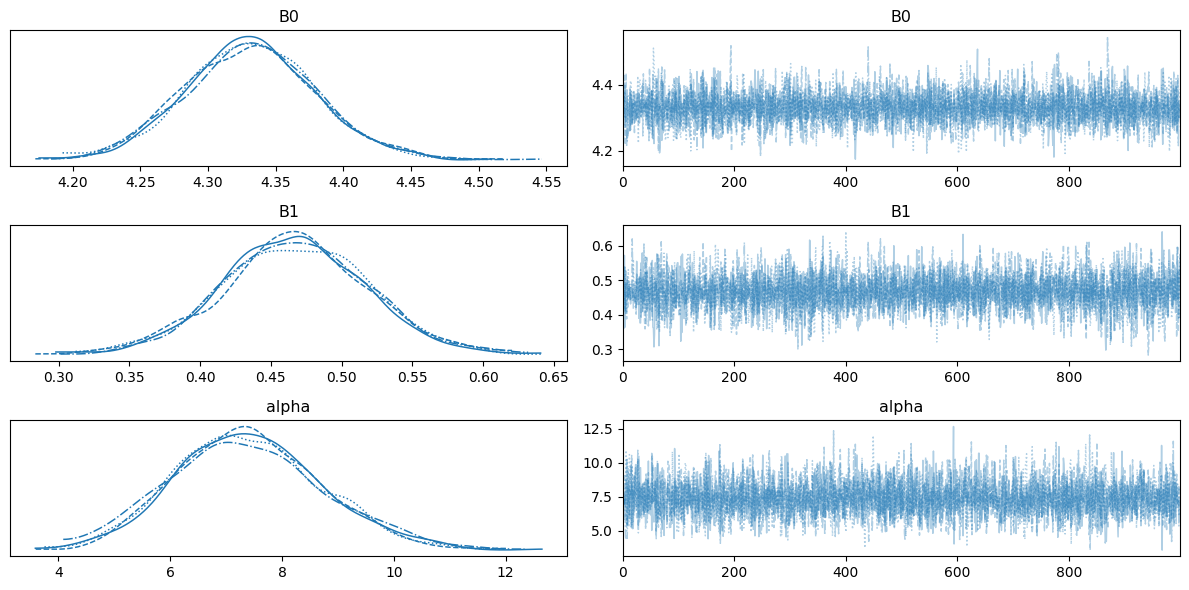

In [5]:
plt.figure(figsize=(8, 5))
pm.plot_trace(trace)
plt.tight_layout()
plt.show()

Y ahora como último paso, voy a ver como ajusta el modelo a los datos que vimos anteriormente en el scatter. Para eso obtengo muestras 
de los datos que quiero graficar:

In [9]:
from scipy import stats

# Obtengo los samples de la posterior
b0_samples = trace.posterior['B0'].values.flatten()
b1_samples = trace.posterior['B1'].values.flatten()
alpha_samples = trace.posterior['alpha'].values.flatten()

# Armo la matriz de predicciones
x_pred_scaled = np.linspace(X_estandarizado.min(), X_estandarizado.max(), 100)
y_pred_samples = np.zeros((len(b0_samples), len(x_pred_scaled)))
y_obs_samples = np.zeros((len(b0_samples), len(x_pred_scaled)))

for i in range(len(b0_samples)):
    # mu = exp(β₀ + β₁x)
    y_pred_samples[i] = np.exp(b0_samples[i] + b1_samples[i] * x_pred_scaled)

    # y ∼ Gamma(alpha, μ/alpha)
    y_obs_samples[i] = stats.gamma.rvs(a=alpha_samples[i], scale=y_pred_samples[i]/alpha_samples[i], size=len(x_pred_scaled))


Y ahora sí, armo el gráfico:

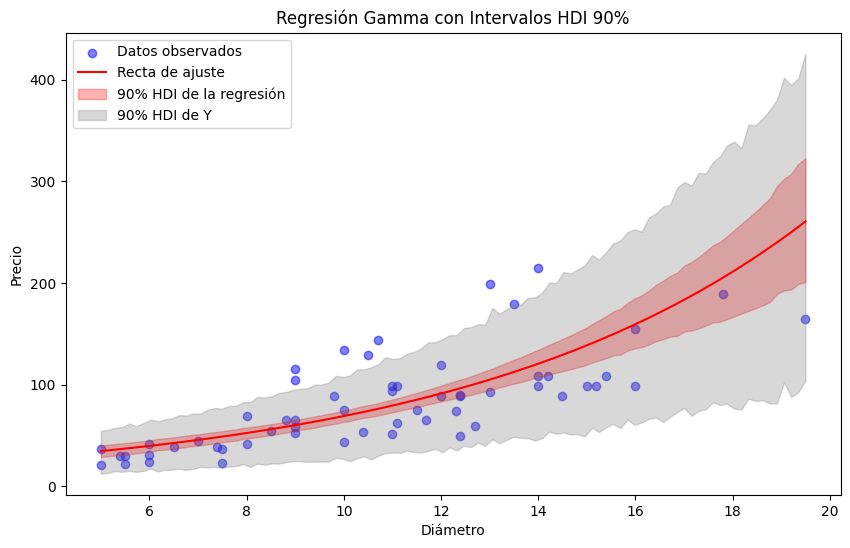

In [11]:
import arviz as az

# Obtengo los 90% HDI para las predicciones y para los datos observados
y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=0.9)
y_obs_hdi = az.hdi(y_obs_samples, hdi_prob=0.9)

# Desestandarizo para el gráfico
x_pred = x_pred_scaled * X.std() + X.mean()

# Gráfico de resultados
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, label="Datos observados", color="blue")
plt.plot(x_pred, y_pred_samples.mean(axis=0), color="red", label="Recta de ajuste")

# 90% HDI de regresión y datos observados
plt.fill_between(x_pred, y_pred_hdi[:, 0], y_pred_hdi[:, 1], color="red", alpha=0.3, label="90% HDI de la regresión")
plt.fill_between(x_pred, y_obs_hdi[:, 0], y_obs_hdi[:, 1], color="gray", alpha=0.3, label="90% HDI de Y")

plt.xlabel("Diámetro")
plt.ylabel("Precio")
plt.title("Regresión Gamma con Intervalos HDI 90%")
plt.legend()
plt.show()